## 1. Imports and Configuration

In [1]:
## 1. Imports and Configuration

import sys
from pathlib import Path
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from loguru import logger

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Import synchronous NWS Forecast adapter
from scripts.api.services.nws_forecast.nws_forecast_sync_adapter import (
    NWSDailyForecastSyncAdapter
)

# Configure logging
logger.remove()
logger.add(sys.stdout, level="INFO")

# Configure plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Imports completed - NWS Forecast with ETo variables")

Imports completed - NWS Forecast with ETo variables


## 2. Initialize NWS Forecast Client

In [2]:
# Create synchronous adapter
nws_adapter = NWSDailyForecastSyncAdapter()

# Get API information
info = nws_adapter.get_info()
print("\n" + "="*60)
print("NWS Forecast API Information")
print("="*60)
print(f"API: {info['api_name']}")
print(f"Coverage: {info['coverage']}")
print(f"License: {info['license']}")
print(f"Forecast Period: {info['forecast_period']}")
print(f"Temporal Resolution: {info['temporal_resolution']}")
print("\nETo Variables Available:")
for var in info['eto_variables']:
    print(f"  - {var}")
print(f"\nSolar Radiation Method: {info['solar_radiation_method']}")
print(f"Reference: {info['solar_radiation_reference']}")
print("="*60)

2025-11-30 04:13:20.602 | INFO     | scripts.api.services.nws_forecast.nws_forecast_client:__init__:276 - NWSForecastClient initialized | base_url=https://api.weather.gov

NWS Forecast API Information
API: National Weather Service (NOAA)
Coverage: USA Continental + Alaska/Hawaii
License: US Government Public Domain
Forecast Period: 5 days
Temporal Resolution: Hourly (aggregated to daily by client)

ETo Variables Available:
  - Temperature (official max/min from NWS)
  - Humidity (mean)
  - Wind speed at 2m (FAO-56 converted)
  - Dewpoint (mean)
  - Atmospheric pressure (estimated from elevation)
  - Solar radiation (USA-ASOS calibrated with vapor correction)
  - Precipitation (estimate, may be overestimated)

Solar Radiation Method: Ångström-Prescott (USA-ASOS a=0.20, b=0.79)
Reference: Belcher & DeGaetano (2007) Solar Energy 81(3):329-345 DOI:10.1016/j.solener.2006.07.003


## 3. Download Forecast - New York City, NY

Let's download the official NOAA forecast for **New York City**.

**Coordinates**: 40.7128°N, -74.0060°W  
**Period**: Next 5 days (forecast)

**New Features (2025)**:
- **Solar Radiation**: Estimated using USA-ASOS calibrated method (Belcher & DeGaetano 2007)
- **Official Temperatures**: Max/Min from NWS 12h/24h periods (more accurate)
- **Wind at 2m**: FAO-56 converted for ETo calculation
- **Dewpoint & Pressure**: For vapor pressure and psychrometric constant

In [3]:
# Define location: New York City
lat_ny = 40.7128
lon_ny = -74.0060
location_name = "New York City, NY"

start_date = datetime.now()
end_date = start_date + timedelta(days=5)

print(f"Location: {location_name}")
print(f"Coordinates: {lat_ny:.4f}°, {lon_ny:.4f}°")
print(f"Period: Forecast for next 5 days")

Location: New York City, NY
Coordinates: 40.7128°, -74.0060°
Period: Forecast for next 5 days


In [4]:
# Download forecast
%pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()

print("\nDownloading forecast from NWS (NOAA)...\n")

nws_forecast = nws_adapter.get_daily_data_sync(
    lat=lat_ny,
    lon=lon_ny,
    start_date=start_date,
    end_date=end_date
)

print(f"\nForecast downloaded: {len(nws_forecast)} daily records")


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


2025-11-30 04:13:23.581 | INFO     | scripts.api.services.nws_forecast.nws_forecast_client:__init__:276 - NWSForecastClient initialized | base_url=https://api.weather.gov
2025-11-30 04:13:25.613 | WARNING  | scripts.api.services.nws_forecast.nws_forecast_client:get_daily_forecast_data:972 - Discarding 2025-11-30: only 19 hours (partial days cause statistical bias)
2025-11-30 04:13:25.618 | INFO     | scripts.api.services.nws_forecast.nws_forecast_client:get_daily_forecast_data:1125 - Retrieved 5 forecast days (160 total hours)
2025-11-30 04:13:25.618 | INFO     | scripts.api.services.nws_forecast.nws_forecast_sync_adapter:_get_daily_data_async:195 - NWS Forecast: 5 days in requested period for (40.7128, -74.006)

Forecast downloaded: 5 daily records


## 4. Convert to DataFrame and Explore

In [5]:
# Convert to DataFrame
df = pd.DataFrame([record.dict() for record in nws_forecast])

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Display first rows
print("\n" + "="*80)
print("NWS Forecast Data (First 3 days)")
print("="*80)
display(df)

# Show available ETo variables
print("\n" + "="*80)
print("ETo Variables Summary")
print("="*80)
eto_vars = [
    'temp_mean', 'temp_max', 'temp_min',
    'humidity_mean', 'wind_speed_mean', 
    'dewpoint_mean', 'pressure_mean',
    'solar_radiation', 'precipitation_sum'
]
print(df[eto_vars].describe())

# Check for completeness
print("\n" + "="*80)
print("Data Completeness")
print("="*80)
completeness = (df[eto_vars].notna().sum() / len(df) * 100).round(1)
for var in eto_vars:
    status = "[OK]" if completeness[var] == 100 else "[WARNING]"
    print(f"{status} {var}: {completeness[var]}%")


NWS Forecast Data (First 3 days)


C:\Users\User\AppData\Local\Temp\ipykernel_20428\2567290011.py:2: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  df = pd.DataFrame([record.dict() for record in nws_forecast])


,date,temp_max,temp_min,temp_mean,humidity_mean,wind_speed_mean,dewpoint_mean,pressure_mean,solar_radiation,precipitation_sum,precipitation_probability,short_forecast
0,2025-12-01,5.000000,2.777778,4.869281,62.866667,3.617162,-1.176471,1013.25,11.68,0.000000,4.000000,None
1,2025-12-02,5.000000,1.111111,2.833333,72.625000,2.578190,-0.520833,1013.25,7.82,23.367999,62.400000,None
2,2025-12-03,3.888889,1.111111,2.820513,72.777778,4.361117,-0.454545,1013.25,10.47,NaN,21.666667,None
3,2025-12-04,4.444444,1.111111,3.055556,67.625000,4.296983,-2.500000,1013.25,9.49,NaN,2.000000,None
4,2025-12-05,2.222222,-3.333333,-0.116959,59.500000,3.527374,-6.543210,1013.25,9.76,NaN,7.000000,None



ETo Variables Summary
       temp_mean  temp_max  temp_min  humidity_mean  wind_speed_mean  \
count   5.000000  5.000000  5.000000       5.000000         5.000000   
mean    2.692345  4.111111  0.555556      67.078889         3.676165   
std     1.788817  1.152025  2.290614       5.888915         0.722105   
min    -0.116959  2.222222 -3.333333      59.500000         2.578190   
25%     2.820513  3.888889  1.111111      62.866667         3.527374   
50%     2.833333  4.444444  1.111111      67.625000         3.617162   
75%     3.055556  5.000000  1.111111      72.625000         4.296983   
max     4.869281  5.000000  2.777778      72.777778         4.361117   

       dewpoint_mean  pressure_mean  solar_radiation  precipitation_sum  
count       5.000000           5.00         5.000000           2.000000  
mean       -2.239012        1013.25         9.844000          11.684000  
std         2.542621           0.00         1.413482          16.523671  
min        -6.543210        1013

## 5. Visualizations

### 5.1 Temperatures (Forecast)

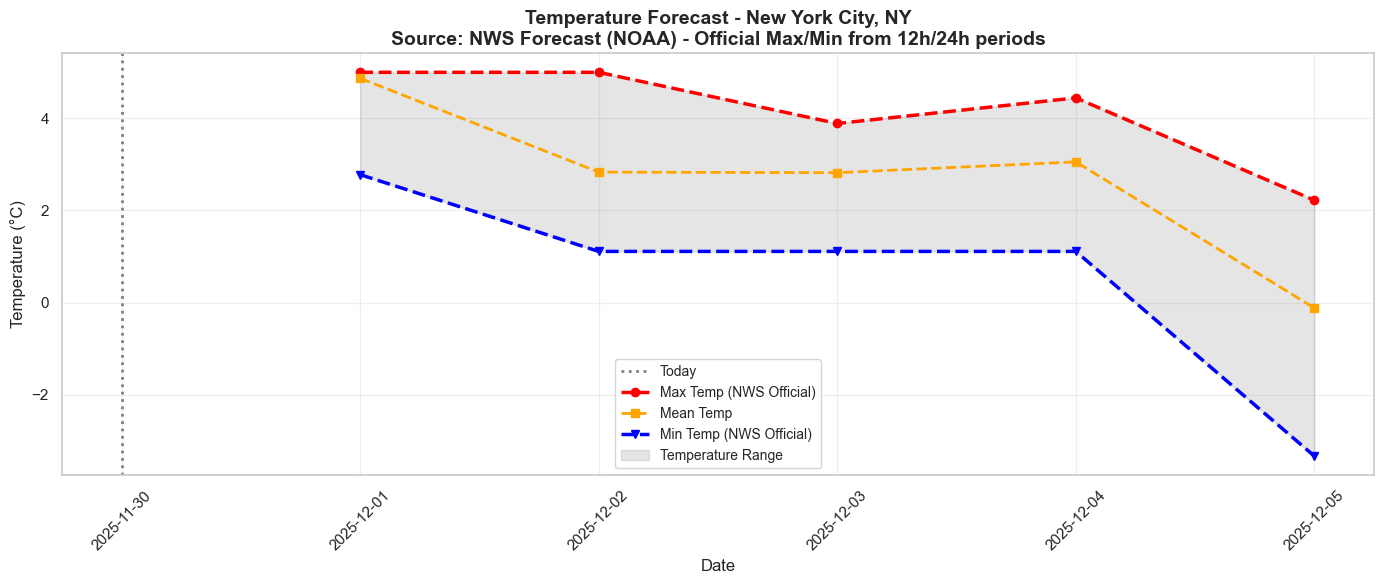

Temperature Range: -3.3°C to 5.0°C


In [6]:
fig, ax = plt.subplots(figsize=(14, 6))

# Vertical line for "today"
today = pd.Timestamp.now().normalize()
ax.axvline(x=today, color='gray', linestyle=':', linewidth=2, label='Today')

# Temperature forecast (using official NWS max/min)
ax.plot(df['date'], df['temp_max'], label='Max Temp (NWS Official)', 
        color='red', linewidth=2.5, marker='o', linestyle='--')
ax.plot(df['date'], df['temp_mean'], label='Mean Temp', 
        color='orange', linewidth=2, marker='s', linestyle='--')
ax.plot(df['date'], df['temp_min'], label='Min Temp (NWS Official)', 
        color='blue', linewidth=2.5, marker='v', linestyle='--')

ax.fill_between(df['date'], df['temp_min'], df['temp_max'], 
                alpha=0.2, color='gray', label='Temperature Range')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Temperature (°C)', fontsize=12)
ax.set_title(
    f'Temperature Forecast - {location_name}\n'
    'Source: NWS Forecast (NOAA) - Official Max/Min from 12h/24h periods', 
    fontsize=14, fontweight='bold'
)
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Temperature Range: {df['temp_min'].min():.1f}°C to {df['temp_max'].max():.1f}°C")

### 5.2 Precipitation (Forecast)

**Note**: Precipitation values are **estimates only**. The NWS API returns accumulated values over periods (6h/12h/24h), not hourly rates. Daily totals may be overestimated.

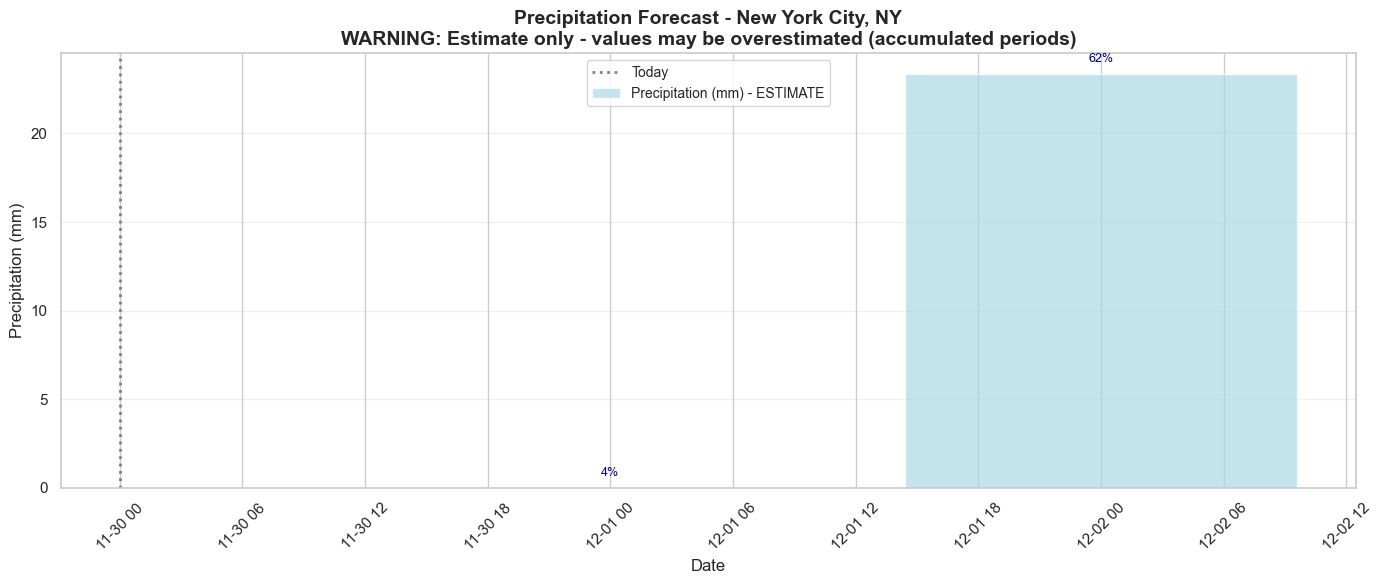

Total Precipitation (5 days): 23.4 mm (estimate)


In [7]:
fig, ax = plt.subplots(figsize=(14, 6))

# Vertical line for "today"
ax.axvline(x=today, color='gray', linestyle=':', linewidth=2, label='Today')

# Precipitation forecast (quantitative - ESTIMATE)
bars = ax.bar(df['date'], df['precipitation_sum'], 
              color='lightblue', alpha=0.7, label='Precipitation (mm) - ESTIMATE')

# Add probability as text on bars
if 'precipitation_probability' in df.columns:
    for i, (date, precip, prob) in enumerate(
        zip(df['date'], df['precipitation_sum'], df['precipitation_probability'])
    ):
        if pd.notna(prob) and prob > 0:
            ax.text(date, precip + 0.5, f'{prob:.0f}%', 
                   ha='center', va='bottom', fontsize=9, color='darkblue')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Precipitation (mm)', fontsize=12)
ax.set_title(
    f'Precipitation Forecast - {location_name}\n'
    'WARNING: Estimate only - values may be overestimated (accumulated periods)', 
    fontsize=14, fontweight='bold'
)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

total_precip = df['precipitation_sum'].sum()
print(f"Total Precipitation (5 days): {total_precip:.1f} mm (estimate)")

### 5.3 Humidity and Wind Speed (ETo Variables)

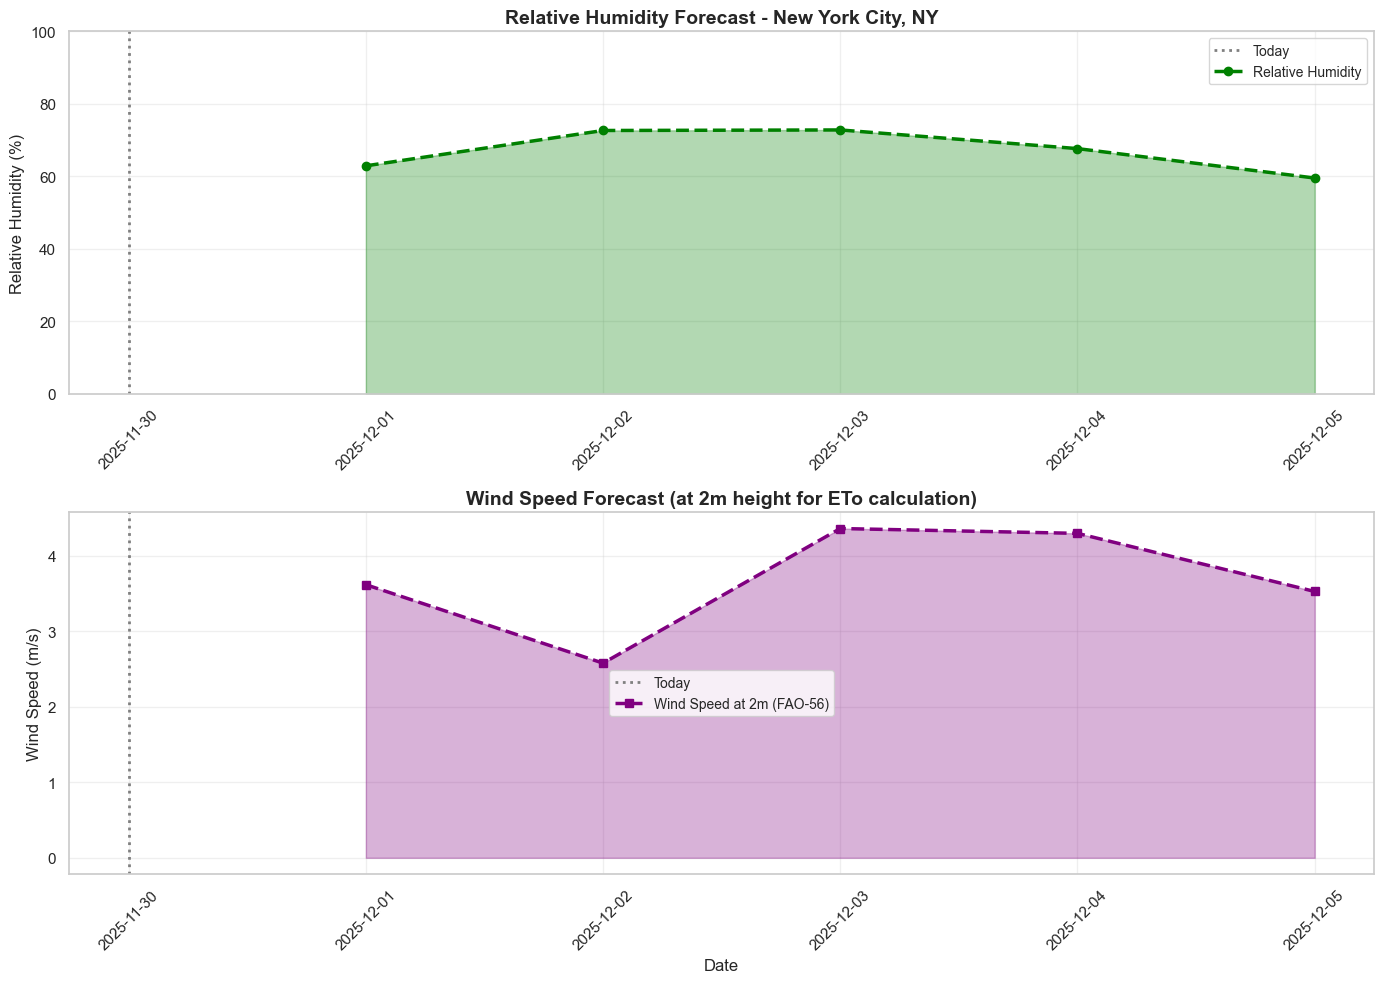

Average Wind Speed: 3.68 m/s
Average Humidity: 67.1%


In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Relative Humidity
ax1.axvline(x=today, color='gray', linestyle=':', linewidth=2, label='Today')
ax1.plot(df['date'], df['humidity_mean'], color='green', 
         linewidth=2.5, marker='o', linestyle='--', label='Relative Humidity')
ax1.fill_between(df['date'], df['humidity_mean'], alpha=0.3, color='green')
ax1.set_ylabel('Relative Humidity (%)', fontsize=12)
ax1.set_title(f'Relative Humidity Forecast - {location_name}', 
              fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 100)

# Wind Speed at 2m (FAO-56 converted)
ax2.axvline(x=today, color='gray', linestyle=':', linewidth=2, label='Today')
ax2.plot(df['date'], df['wind_speed_mean'], color='purple', 
         linewidth=2.5, marker='s', linestyle='--', 
         label='Wind Speed at 2m (FAO-56)')
ax2.fill_between(df['date'], df['wind_speed_mean'], alpha=0.3, color='purple')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Wind Speed (m/s)', fontsize=12)
ax2.set_title('Wind Speed Forecast (at 2m height for ETo calculation)', 
              fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
plt.tight_layout()
plt.show()

print(f"Average Wind Speed: {df['wind_speed_mean'].mean():.2f} m/s")
print(f"Average Humidity: {df['humidity_mean'].mean():.1f}%")

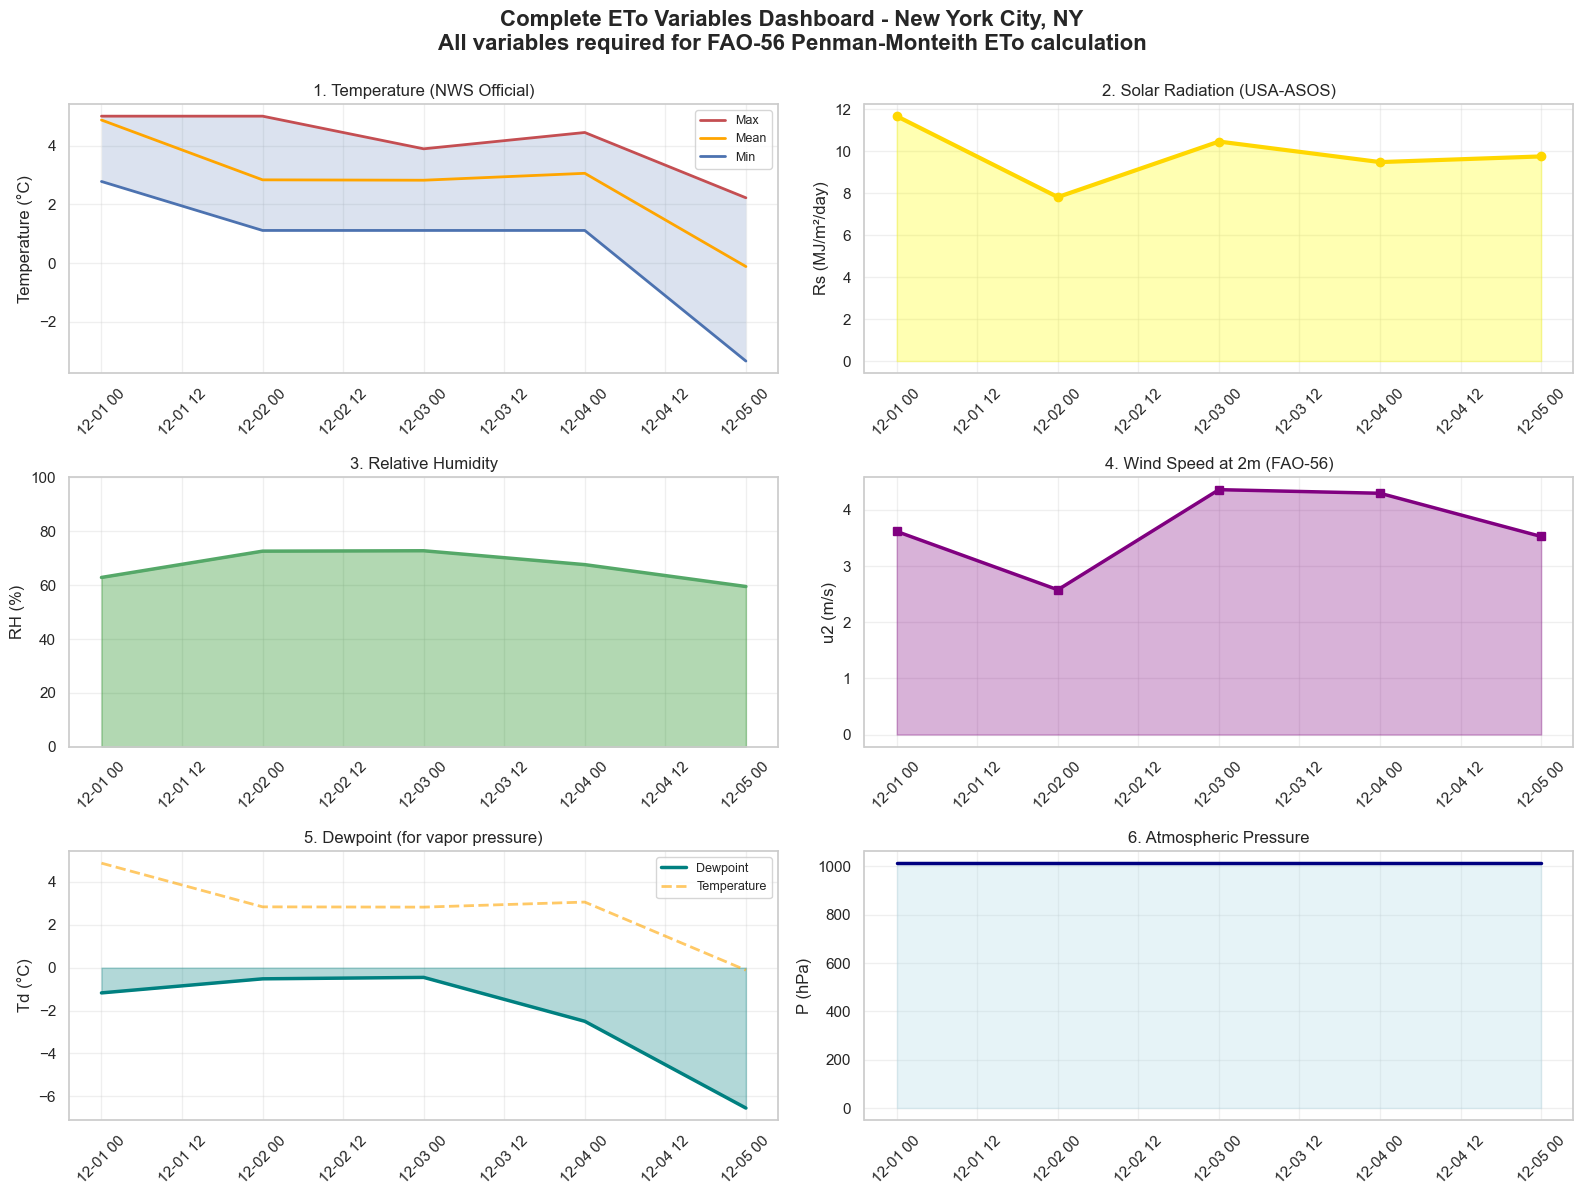


ALL ETo VARIABLES AVAILABLE
Ready for FAO-56 Penman-Monteith ETo calculation!


In [9]:
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle(
    f'Complete ETo Variables Dashboard - {location_name}\n'
    'All variables required for FAO-56 Penman-Monteith ETo calculation',
    fontsize=16, fontweight='bold', y=0.995
)

# 1. Temperature
ax = axes[0, 0]
ax.plot(df['date'], df['temp_max'], 'r-', linewidth=2, label='Max')
ax.plot(df['date'], df['temp_mean'], 'orange', linewidth=2, label='Mean')
ax.plot(df['date'], df['temp_min'], 'b-', linewidth=2, label='Min')
ax.fill_between(df['date'], df['temp_min'], df['temp_max'], alpha=0.2)
ax.set_ylabel('Temperature (°C)')
ax.set_title('1. Temperature (NWS Official)')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# 2. Solar Radiation
ax = axes[0, 1]
ax.plot(df['date'], df['solar_radiation'], 'gold', linewidth=3, marker='o')
ax.fill_between(df['date'], df['solar_radiation'], alpha=0.3, color='yellow')
ax.set_ylabel('Rs (MJ/m²/day)')
ax.set_title('2. Solar Radiation (USA-ASOS)')
ax.grid(True, alpha=0.3)

# 3. Humidity
ax = axes[1, 0]
ax.plot(df['date'], df['humidity_mean'], 'g-', linewidth=2.5)
ax.fill_between(df['date'], df['humidity_mean'], alpha=0.3, color='green')
ax.set_ylabel('RH (%)')
ax.set_title('3. Relative Humidity')
ax.set_ylim(0, 100)
ax.grid(True, alpha=0.3)

# 4. Wind Speed
ax = axes[1, 1]
ax.plot(df['date'], df['wind_speed_mean'], 'purple', linewidth=2.5, marker='s')
ax.fill_between(df['date'], df['wind_speed_mean'], alpha=0.3, color='purple')
ax.set_ylabel('u2 (m/s)')
ax.set_title('4. Wind Speed at 2m (FAO-56)')
ax.grid(True, alpha=0.3)

# 5. Dewpoint
ax = axes[2, 0]
ax.plot(df['date'], df['dewpoint_mean'], 'teal', linewidth=2.5)
ax.plot(df['date'], df['temp_mean'], 'orange', linewidth=2, linestyle='--', alpha=0.6)
ax.fill_between(df['date'], df['dewpoint_mean'], alpha=0.3, color='teal')
ax.set_ylabel('Td (°C)')
ax.set_title('5. Dewpoint (for vapor pressure)')
ax.legend(['Dewpoint', 'Temperature'], fontsize=9)
ax.grid(True, alpha=0.3)

# 6. Pressure
ax = axes[2, 1]
ax.plot(df['date'], df['pressure_mean'], 'navy', linewidth=2.5)
ax.fill_between(df['date'], df['pressure_mean'], alpha=0.3, color='lightblue')
ax.set_ylabel('P (hPa)')
ax.set_title('6. Atmospheric Pressure')
ax.grid(True, alpha=0.3)

# Rotate x-axis labels
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("ALL ETo VARIABLES AVAILABLE")
print("="*80)
print("Ready for FAO-56 Penman-Monteith ETo calculation!")

### 5.6 Complete ETo Variables Dashboard

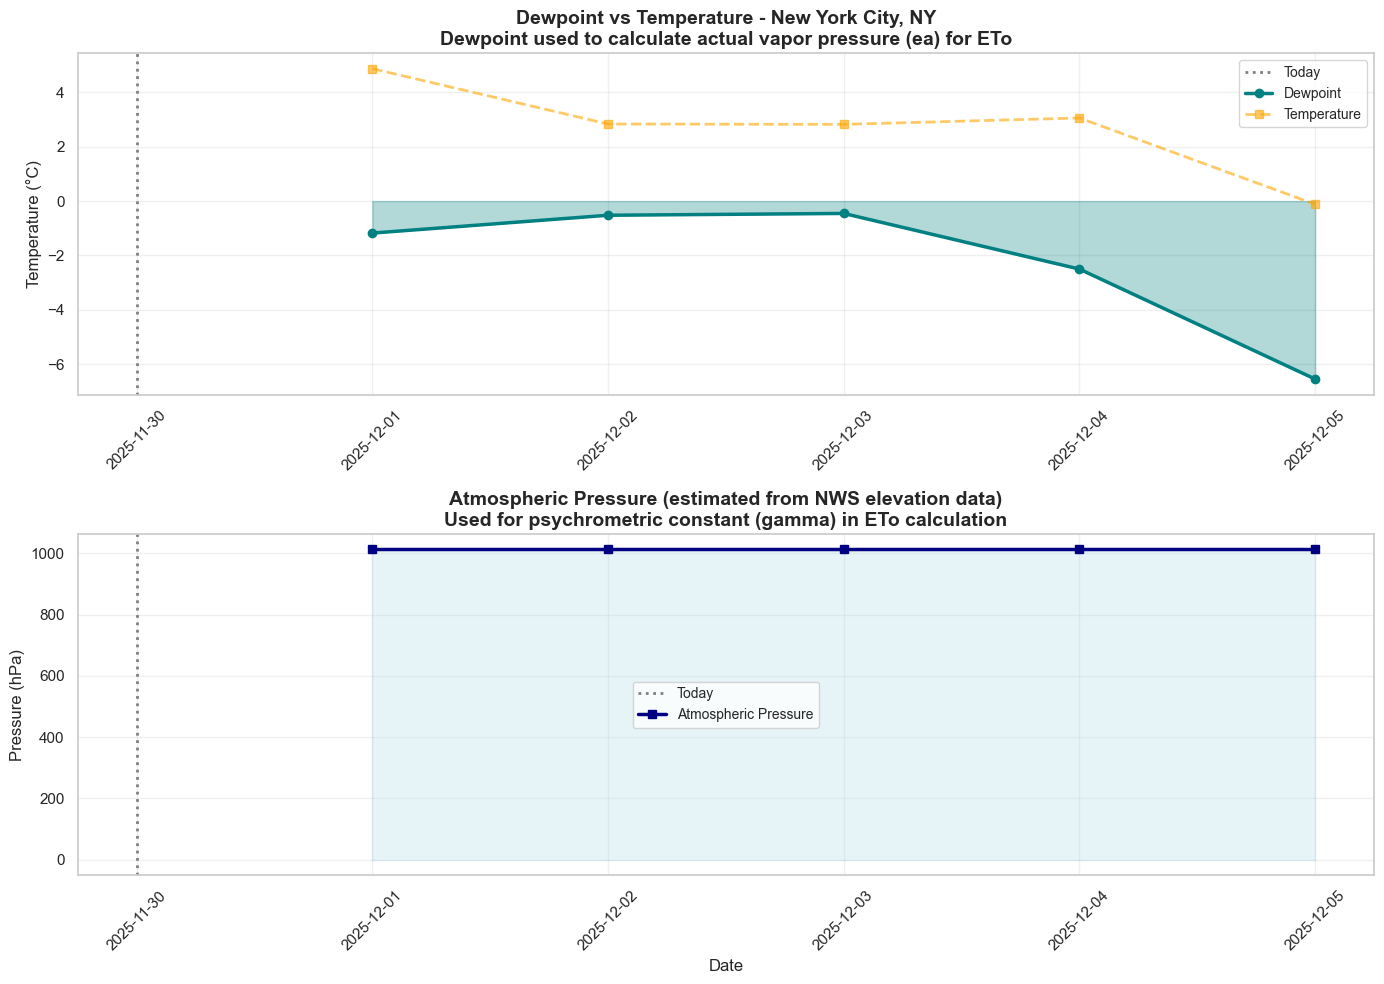

Average Dewpoint: -2.24°C
Average Pressure: 1013.25 hPa
Dewpoint Depression: 4.93°C


In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Dewpoint (for vapor pressure calculation)
ax1.axvline(x=today, color='gray', linestyle=':', linewidth=2, label='Today')
ax1.plot(df['date'], df['dewpoint_mean'], color='teal', 
         linewidth=2.5, marker='o', linestyle='-', label='Dewpoint')
ax1.plot(df['date'], df['temp_mean'], color='orange', 
         linewidth=2, marker='s', linestyle='--', alpha=0.6, label='Temperature')
ax1.fill_between(df['date'], df['dewpoint_mean'], alpha=0.3, color='teal')
ax1.set_ylabel('Temperature (°C)', fontsize=12)
ax1.set_title(
    f'Dewpoint vs Temperature - {location_name}\n'
    'Dewpoint used to calculate actual vapor pressure (ea) for ETo', 
    fontsize=14, fontweight='bold'
)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Atmospheric Pressure (estimated from elevation)
ax2.axvline(x=today, color='gray', linestyle=':', linewidth=2, label='Today')
ax2.plot(df['date'], df['pressure_mean'], color='navy', 
         linewidth=2.5, marker='s', linestyle='-', label='Atmospheric Pressure')
ax2.fill_between(df['date'], df['pressure_mean'], alpha=0.3, color='lightblue')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Pressure (hPa)', fontsize=12)
ax2.set_title(
    'Atmospheric Pressure (estimated from NWS elevation data)\n'
    'Used for psychrometric constant (gamma) in ETo calculation', 
    fontsize=14, fontweight='bold'
)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
plt.tight_layout()
plt.show()

print(f"Average Dewpoint: {df['dewpoint_mean'].mean():.2f}°C")
print(f"Average Pressure: {df['pressure_mean'].mean():.2f} hPa")
print(f"Dewpoint Depression: {(df['temp_mean'] - df['dewpoint_mean']).mean():.2f}°C")

### 5.5 **NEW**: Dewpoint and Atmospheric Pressure (ETo Variables)

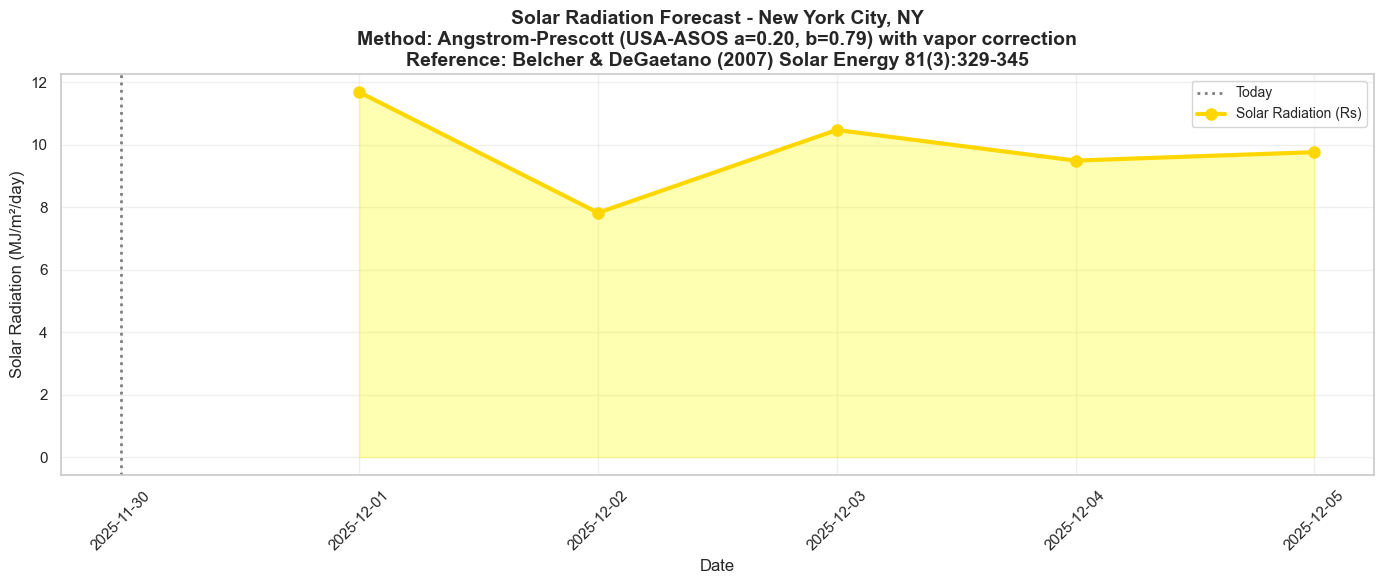

Average Solar Radiation: 9.84 MJ/m²/day
Max Solar Radiation: 11.68 MJ/m²/day
Min Solar Radiation: 7.82 MJ/m²/day


In [11]:
fig, ax = plt.subplots(figsize=(14, 6))

# Vertical line for "today"
ax.axvline(x=today, color='gray', linestyle=':', linewidth=2, label='Today')

# Solar radiation forecast
ax.plot(df['date'], df['solar_radiation'], color='gold', 
        linewidth=3, marker='o', markersize=8, linestyle='-',
        label='Solar Radiation (Rs)')
ax.fill_between(df['date'], df['solar_radiation'], 
                alpha=0.3, color='yellow')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Solar Radiation (MJ/m²/day)', fontsize=12)
ax.set_title(
    f'Solar Radiation Forecast - {location_name}\n'
    'Method: Angstrom-Prescott (USA-ASOS a=0.20, b=0.79) with vapor correction\n'
    'Reference: Belcher & DeGaetano (2007) Solar Energy 81(3):329-345', 
    fontsize=14, fontweight='bold'
)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Average Solar Radiation: {df['solar_radiation'].mean():.2f} MJ/m²/day")
print(f"Max Solar Radiation: {df['solar_radiation'].max():.2f} MJ/m²/day")
print(f"Min Solar Radiation: {df['solar_radiation'].min():.2f} MJ/m²/day")

### 5.4 **NEW**: Solar Radiation (USA-ASOS Calibrated)

## 6. Example 2: San Francisco, CA

In [12]:
# Define location: San Francisco
lat_sf = 37.7749
lon_sf = -122.4194
location_sf = "San Francisco, CA"

print(f"Location: {location_sf}")
print(f"Coordinates: {lat_sf:.4f}°, {lon_sf:.4f}°")

# Download forecast
print("\nDownloading forecast from NWS...\n")

sf_forecast = nws_adapter.get_daily_data_sync(
    lat=lat_sf,
    lon=lon_sf,
    start_date=start_date,
    end_date=end_date
)

print(f"\nForecast downloaded: {len(sf_forecast)} records")

Location: San Francisco, CA
Coordinates: 37.7749°, -122.4194°


2025-11-30 04:13:28.282 | INFO     | scripts.api.services.nws_forecast.nws_forecast_client:__init__:276 - NWSForecastClient initialized | base_url=https://api.weather.gov
2025-11-30 04:13:29.408 | WARNING  | scripts.api.services.nws_forecast.nws_forecast_client:get_daily_forecast_data:972 - Discarding 2025-11-30: only 19 hours (partial days cause statistical bias)
2025-11-30 04:13:29.408 | INFO     | scripts.api.services.nws_forecast.nws_forecast_client:get_daily_forecast_data:1125 - Retrieved 5 forecast days (170 total hours)
2025-11-30 04:13:29.412 | INFO     | scripts.api.services.nws_forecast.nws_forecast_sync_adapter:_get_daily_data_async:195 - NWS Forecast: 5 days in requested period for (37.7749, -122.4194)

Forecast downloaded: 5 records


C:\Users\User\AppData\Local\Temp\ipykernel_20428\482199279.py:2: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  df_sf = pd.DataFrame([record.dict() for record in sf_forecast])


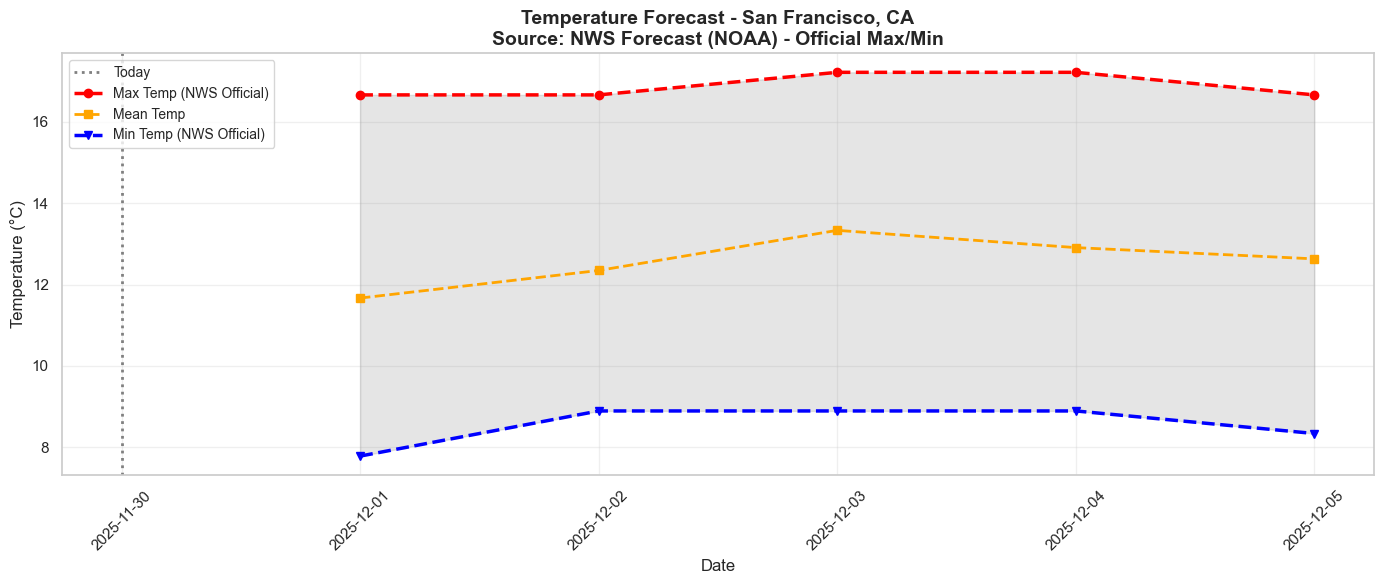


San Francisco Solar Radiation:
   Average: 13.48 MJ/m²/day
   Max: 13.93 MJ/m²/day


In [13]:
# Convert to DataFrame
df_sf = pd.DataFrame([record.dict() for record in sf_forecast])
df_sf['date'] = pd.to_datetime(df_sf['date'])

# Visualize temperatures
fig, ax = plt.subplots(figsize=(14, 6))

ax.axvline(x=today, color='gray', linestyle=':', linewidth=2, label='Today')
ax.plot(df_sf['date'], df_sf['temp_max'], label='Max Temp (NWS Official)', 
        color='red', linewidth=2.5, marker='o', linestyle='--')
ax.plot(df_sf['date'], df_sf['temp_mean'], label='Mean Temp', 
        color='orange', linewidth=2, marker='s', linestyle='--')
ax.plot(df_sf['date'], df_sf['temp_min'], label='Min Temp (NWS Official)', 
        color='blue', linewidth=2.5, marker='v', linestyle='--')
ax.fill_between(df_sf['date'], df_sf['temp_min'], df_sf['temp_max'], 
                alpha=0.2, color='gray')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Temperature (°C)', fontsize=12)
ax.set_title(
    f'Temperature Forecast - {location_sf}\n'
    'Source: NWS Forecast (NOAA) - Official Max/Min', 
    fontsize=14, fontweight='bold'
)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show solar radiation for SF
print(f"\nSan Francisco Solar Radiation:")
print(f"   Average: {df_sf['solar_radiation'].mean():.2f} MJ/m²/day")
print(f"   Max: {df_sf['solar_radiation'].max():.2f} MJ/m²/day")

## 7. Health Check

In [14]:
# Check API availability
is_healthy = nws_adapter.health_check_sync()

print("\n" + "="*60)
if is_healthy:
    print("[OK] NWS Forecast API is working correctly")
else:
    print("[ERROR] NWS Forecast API is not accessible")
print("="*60)

2025-11-30 04:13:29.904 | INFO     | scripts.api.services.nws_forecast.nws_forecast_client:__init__:276 - NWSForecastClient initialized | base_url=https://api.weather.gov

[OK] NWS Forecast API is working correctly


## 8. Save Data

In [15]:
# Save NYC forecast
output_nyc = project_root / "data" / "csv" / "nws_forecast_nyc_demo.csv"
output_nyc.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(output_nyc, index=False)
print(f"\nNYC forecast saved to: {output_nyc}")

# Save San Francisco forecast
output_sf = project_root / "data" / "csv" / "nws_forecast_sf_demo.csv"
df_sf.to_csv(output_sf, index=False)
print(f"SF forecast saved to: {output_sf}")


NYC forecast saved to: c:\Users\User\OneDrive\Documentos\GitHub\EVAONLINE\EVAonline_validation_v1.0.0\data\csv\nws_forecast_nyc_demo.csv
SF forecast saved to: c:\Users\User\OneDrive\Documentos\GitHub\EVAONLINE\EVAonline_validation_v1.0.0\data\csv\nws_forecast_sf_demo.csv


---

## References

**NWS Forecast (National Weather Service - NOAA)**
- Website: https://www.weather.gov/
- API Documentation: https://www.weather.gov/documentation/services-web-api
- Citation: National Weather Service, National Oceanic and Atmospheric Administration (NOAA)

**License**: US Government Public Domain

**Coverage**:
- USA Continental: -125°W to -66°W, 24°N to 49°N
- Extended: Alaska/Hawaii (18°N to 71°N)

**Solar Radiation Method**:
- **Angstrom-Prescott formula** with USA-ASOS calibrated coefficients (a=0.20, b=0.79)
- **Water vapor absorption correction** from dewpoint
- Reference: Belcher, B.N. & DeGaetano, A.T. (2007). *A revised empirical model to estimate solar radiation using automated surface weather observations*. Solar Energy, 81(3), 329-345.
- DOI: [10.1016/j.solener.2006.07.003](https://doi.org/10.1016/j.solener.2006.07.003)
- **Model Performance**: MAE ~10-15% (daily), ~15-19% (hourly)
- **Key Features**: 
  - Revised for automated ASOS weather observations
  - Accounts for regional climate variations
  - Includes water vapor transmittance correction
  - Validated across different sky conditions and seasons

**Elevation Data**:
- Source: NWS API endpoint `/points/{lat},{lon}`
- Field: `properties.elevation.value` (meters)
- Used for atmospheric pressure estimation via barometric formula
- Fallback: Sea level pressure (1013.25 hPa) if elevation unavailable

**ETo Variables (FAO-56 Penman-Monteith)**:
1. Temperature (max/min/mean) - Official NWS values from 12h/24h periods
2. Solar Radiation (Rs) - USA-ASOS calibrated with vapor correction
3. Relative Humidity (RH) - Mean daily
4. Wind Speed (u2) - Converted to 2m height using FAO-56
5. Dewpoint (Td) - For actual vapor pressure (ea)
6. Atmospheric Pressure (P) - Estimated from NWS elevation data
7. Precipitation - Estimate only (may be overestimated due to period accumulation)

---